In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA

pd.set_option ('display.max_columns',None)

In [3]:
marketing = pd.read_csv('/content/drive/MyDrive/Dataset/marketing_campaign_data.csv',index_col=0)
marketing.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,S1,Lajang,58138000.0,0,0,04-09-2012,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,S1,Lajang,46344000.0,1,1,08-03-2014,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,S1,Bertunangan,71613000.0,0,0,21-08-2013,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,S1,Bertunangan,26646000.0,1,0,10-02-2014,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,S3,Menikah,58293000.0,1,0,19-01-2014,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
marketing.info()
# terdapat missing data pada kolom income
# hanya perlu diberi perubahan type data pada kolom dt-customer objek-> date

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntCoke              2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
marketing.isna().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntCoke                 0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [6]:
# cross cek data duplicated sebelum drop kolom ID
marketing.duplicated().sum()

0

In [7]:
# melakukan imputasi data kosong
marketing.Income = marketing.Income.fillna(0)

# mengubah type data
marketing.Dt_Customer= pd.to_datetime(marketing.Dt_Customer)

# membuat kolom Usia
marketing['Year_cust'] = marketing['Dt_Customer'].dt.year
marketing['Age'] = marketing['Year_cust'] - marketing['Year_Birth']

# mengelompokan group usia
marketing['Group_Age'] = marketing['Age'].apply(lambda x: 'Teenger' if x <= 30 else
                                        'Middle age' if x <= 50 else
                                        'Adult' if x <= 65
                                        else 'Ederly')
# membuat kolom total anak
marketing['Ttl_Child'] = marketing['Kidhome'] + marketing['Teenhome']

# melakukan mapping pada kolom Marital
mapping_marital = {'Menikah':'Menikah','Bertunangan':'Bertunangan','Lajang':'Lajang','Cerai':'Cerai','Janda':'Cerai','Duda':'Cerai'}
marketing['Marital_Status'] = marketing['Marital_Status'].map(mapping_marital)


In [8]:
# membuang kolom yang tidak diperlukan
marketing= marketing.drop(columns=['ID','Year_Birth','Kidhome','Teenhome','Year_cust','Z_Revenue','Z_CostContact'], axis=1)

In [9]:
# cross cek data duplicated
marketing.duplicated().sum()

184

In [10]:
# membuang data yang duplikat
marketing= marketing.drop_duplicates()

In [11]:
marketing.head()

,Education,Marital_Status,Income,Dt_Customer,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Group_Age,Ttl_Child
0,S1,Lajang,58138000.0,2012-04-09,58,635000,88000,546000,172000,88000,88000,3,8,10,4,7,0,0,0,0,0,0,1,55,Adult,0
1,S1,Lajang,46344000.0,2014-08-03,38,11000,1000,6000,2000,1000,6000,2,1,1,2,5,0,0,0,0,0,0,0,60,Adult,2
2,S1,Bertunangan,71613000.0,2013-08-21,26,426000,49000,127000,111000,21000,42000,1,8,2,10,4,0,0,0,0,0,0,0,48,Middle age,0
3,S1,Bertunangan,26646000.0,2014-10-02,26,11000,4000,20000,10000,3000,5000,2,2,0,4,6,0,0,0,0,0,0,0,30,Teenger,1
4,S3,Menikah,58293000.0,2014-01-19,94,173000,43000,118000,46000,27000,15000,5,5,3,6,5,0,0,0,0,0,0,0,33,Middle age,1


### Label Encoder

In [12]:
from sklearn.preprocessing import OneHotEncoder
kateg = marketing[['Education','Marital_Status','Group_Age']]
name_col =['Education','Marital_Status','Group_Age']

encoder= OneHotEncoder(sparse=False)
one_hot = pd.DataFrame(encoder.fit_transform(kateg),
                       columns=encoder.get_feature_names_out(name_col))

### Standarisasi

In [13]:
from sklearn.preprocessing import StandardScaler
numeric = marketing.select_dtypes(exclude=['object','datetime64'])
scaler = StandardScaler()
df_scale = pd.DataFrame(scaler.fit_transform(numeric),
                        columns = numeric.columns)

In [14]:
# mengganbung kedua df
df_comb = pd.concat([df_scale,one_hot], axis=1)

In [15]:
df_comb.head()

,Income,Recency,MntCoke,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Ttl_Child,Education_D3,Education_S1,Education_S2,Education_S3,Education_SMA,Marital_Status_Bertunangan,Marital_Status_Cerai,Marital_Status_Lajang,Marital_Status_Menikah,Group_Age_Adult,Group_Age_Ederly,Group_Age_Middle age,Group_Age_Teenger
0,0.245471,0.311169,0.983352,1.553127,1.656297,2.463165,1.457417,0.846129,0.340777,1.394958,2.500801,-0.547227,0.689171,-0.280533,-0.288523,-0.278511,-0.265096,-0.113172,-0.099112,2.368741,0.894943,-1.275021,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-0.208200,-0.378788,-0.870759,-0.635394,-0.708837,-0.646935,-0.628062,-0.726662,-0.174019,-1.108001,-0.566601,-1.164734,-0.130578,-0.280533,-0.288523,-0.278511,-0.265096,-0.113172,-0.099112,-0.422165,1.311139,1.397194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.763803,-0.792762,0.362343,0.572065,-0.178872,1.347188,-0.148641,-0.036168,-0.688815,1.394958,-0.225778,1.305295,-0.540452,-0.280533,-0.288523,-0.278511,-0.265096,-0.113172,-0.099112,-0.422165,0.312268,-1.275021,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.965908,-0.792762,-0.870759,-0.559928,-0.647519,-0.500577,-0.580120,-0.745843,-0.174019,-0.750435,-0.907423,-0.547227,0.279297,-0.280533,-0.288523,-0.278511,-0.265096,-0.113172,-0.099112,-0.422165,-1.186037,0.061087,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.251433,1.553091,-0.389403,0.421133,-0.218291,0.158032,-0.004815,-0.554039,1.370368,0.322261,0.115044,0.070280,-0.130578,-0.280533,-0.288523,-0.278511,-0.265096,-0.113172,-0.099112,-0.422165,-0.936320,0.061087,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Elbow Method

Inertia Score for k =1: 49293.568093385176
Inertia Score for k =2: 39179.210598456586
Inertia Score for k =3: 36299.254486528924
Inertia Score for k =4: 33961.2726608948
Inertia Score for k =5: 31999.567069864348
Inertia Score for k =6: 30930.615130869915
Inertia Score for k =7: 29857.758688331123
Inertia Score for k =8: 28211.42475299191
Inertia Score for k =9: 26824.71453736315


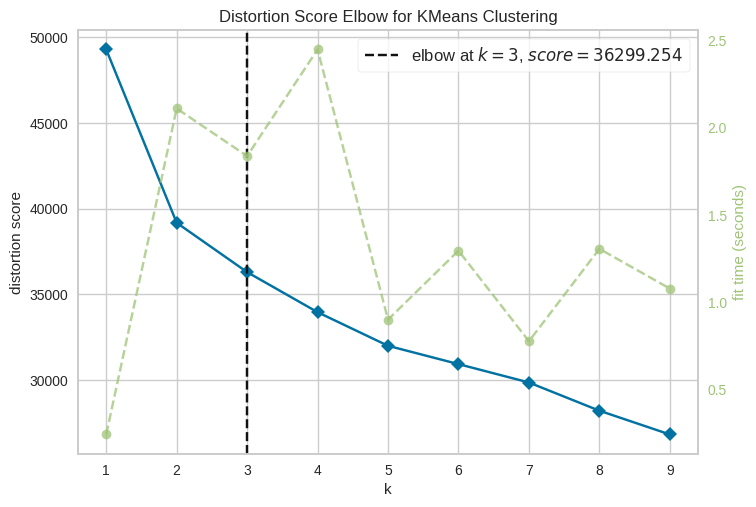

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
inertia = []
range_val = range(1, 10)
random_state = 42
for i in range_val:
  kmean = KMeans(n_clusters=i, random_state= random_state)
  kmean.fit_predict(pd.DataFrame(df_comb))
  inertia.append(kmean.inertia_)

for k, score in enumerate(inertia, start=1):
  print(f'Inertia Score for k ={k}: {score}')

km = KMeans(random_state=42)
Visualizer = KElbowVisualizer(km, k=(1, 10))
Visualizer.fit(df_comb)
Visualizer.show()

Dari hasil algoritma elbow didapat nilai k optimal berada di angka 3

### Silhoutte Score

Silhoutte Score for k= 2: 0.25385151515841936
Silhoutte Score for k= 3: 0.16398886830485493
Silhoutte Score for k= 4: 0.16147590805257492
Silhoutte Score for k= 5: 0.16979880790799784
Silhoutte Score for k= 6: 0.17020225666396627
Silhoutte Score for k= 7: 0.16448315589194473
Silhoutte Score for k= 8: 0.1510566651085985
Silhoutte Score for k= 9: 0.09043308175063969


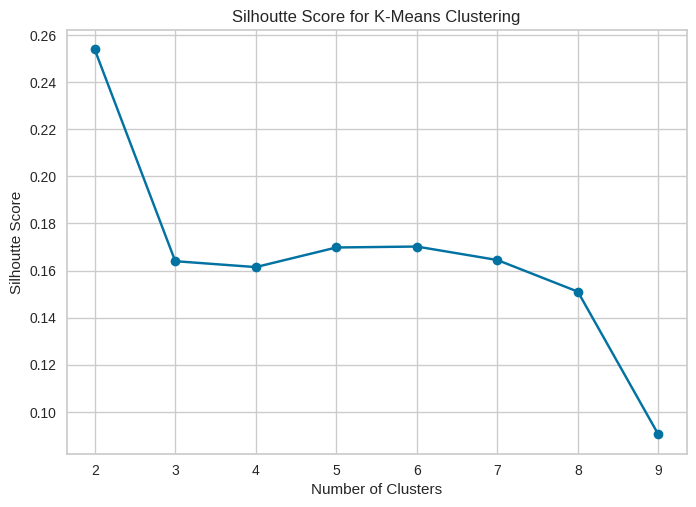

In [17]:
silhouette_scores = []

for k in range (2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_comb)
    labels = kmeans.labels_

    score = silhouette_score(df_comb, labels)
    silhouette_scores.append(score)

for k, score in enumerate(silhouette_scores, start=2):
    print(f'Silhoutte Score for k= {k}: {score}')

plt.plot(range(2, 10), silhouette_scores, marker ='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Silhoutte Score for K-Means Clustering')
plt.show()

Setelah dilakukan evaluasi dengan algoritma Silhouette Score nilai k optimal berada pada angka 3. Hasil ini sesuai dengan hasil algoritma Elbow.

In [18]:
k = 3

### PCA optimal

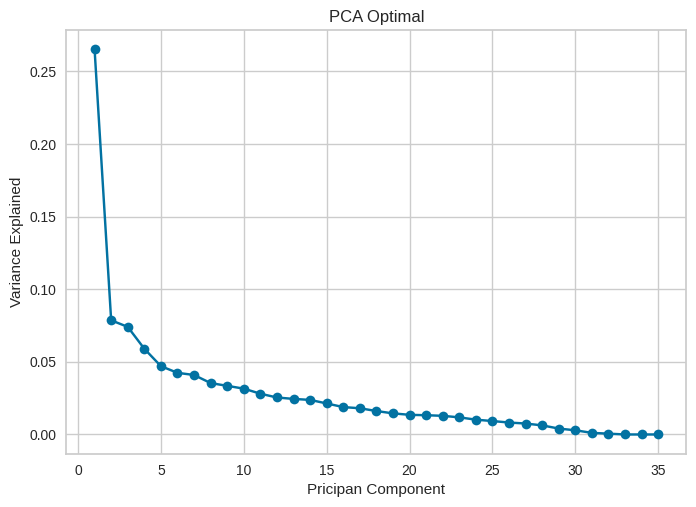

In [22]:
X = df_comb.values
pca = PCA()
pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker ='o')
plt.xlabel('Pricipan Component')
plt.ylabel('Variance Explained')
plt.title('PCA Optimal')
plt.show()

nilai PCA paling optimal ada pada kisaran 2-3 maka saya memutuskan untuk menggunakan angka 2 untuk langkah selanjutnya  

In [24]:
# membuat PCA
pca = PCA(n_components=2)
pricipal_component = pca.fit_transform(df_comb)
pca_df = pd.DataFrame(data = pricipal_component, columns=['PCA1','PCA2'])
pca_df.head()

,PCA1,PCA2
0,3.855571,-0.295840
1,-2.353990,-0.253649
2,1.630780,-1.041908
3,-2.260518,-0.337023
4,-0.292978,-0.539965


In [26]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(df_comb)
df_kmean = pd.concat([pca_df, pd.DataFrame({'Cluster':kmeans.labels_})], axis=1)
df_kmean.head()

,PCA1,PCA2,Cluster
0,3.855571,-0.295840,2
1,-2.353990,-0.253649,1
2,1.630780,-1.041908,0
3,-2.260518,-0.337023,1
4,-0.292978,-0.539965,0


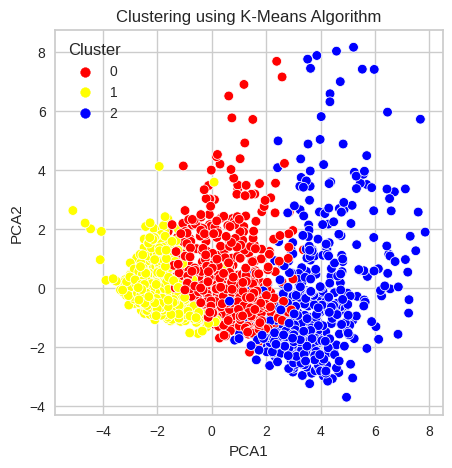

In [28]:
plt.figure(figsize=(5,5))
a = sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_kmean, palette =['red','yellow','blue'])
plt.title('Clustering using K-Means Algorithm')
plt.show()